In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=ac722c4042a691df3e3365b3aa8de9a5e1e287966ba676c6d780cacf2da881f8
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
cd drive/My Drive/isdp/classification

/content/drive/My Drive/isdp/classification


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import shutil
from efficientnet_pytorch import EfficientNet

In [ ]:
import numpy as np
import glob
import os
import shutil


def split_dataset(train_project, test_project):
    save_path   = 'data/img/'
    color_path  = 'gray_img/'
    txt_path    = 'data/txt/'
    path_project_img = save_path + color_path + txt_path

    path_train = 'data/train/'
    path_test = 'data/val/'
    for i in ['0', '1']:
        if not os.path.exists(path_train + i):
            os.makedirs(path_train + i)
        if not os.path.exists(path_test + i):
            os.makedirs(path_test + i)

    clean_list, buggy_list = [], []
    for tp in train_project:
        for project_img_file in glob.glob(path_project_img + tp):
            clean_list.append(glob.glob(project_img_file + '/split_clean' + '/*/*.png'))
            buggy_list.append(glob.glob(project_img_file + '/split_buggy' + '/*/*.png'))

        for img_path in clean_list[0]:
            save_path = path_train + '0/' +\
                        img_path[img_path.find('/split_clean') + len('/split_clean'):].replace('\\', '', 1).replace('\\', '_')
            shutil.copy(img_path, save_path)

        for img_path in buggy_list[0]:
            save_path = path_train + '1/' +\
                        img_path[img_path.find('/split_buggy') + len('/split_buggy'):].replace('\\', '', 1).replace('\\', '_')
            shutil.copy(img_path, save_path)

    clean_list, buggy_list = [], []
    for tp in test_project:
        for project_img_file in glob.glob(path_project_img + tp):
            clean_list.append(glob.glob(project_img_file + '/split_clean' + '/*/*.png'))
            buggy_list.append(glob.glob(project_img_file + '/split_buggy' + '/*/*.png'))

        for img_path in clean_list[0]:
            save_path = path_test + '0/' + \
                        img_path[img_path.find('/split_clean') + len('/split_clean'):].replace('\\', '', 1).replace(
                            '\\', '_')
            shutil.copy(img_path, save_path)

        for img_path in buggy_list[0]:
            save_path = path_test + '1/' + \
                        img_path[img_path.find('/split_buggy') + len('/split_buggy'):].replace('\\', '', 1).replace(
                            '\\', '_')
            shutil.copy(img_path, save_path)


if __name__ == "__main__":
    split_dataset(['ant-1.5'], ['ant-1.6'])


In [ ]:
dataset_dir = './dataset/'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
dirlist = os.listdir(dataset_dir)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
              for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


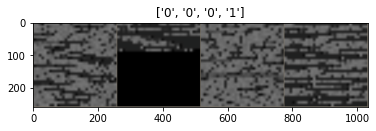

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # epoch pass ...
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # repeat
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # grads of parameters are 0
                optimizer.zero_grad()

                # foreward + log
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optim
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=2)

# # fc 제외하고 freeze
for n, p in model.named_parameters():
    if '_fc' not in n:
        p.requires_grad = False
# model = torch.nn.parallel.DistributedDataParallel(model)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# optim?
optimizer_ft = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.5, 0.99))

# step_size 마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
# lmbda = lambda epoch: 0.98739
# exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7


https://keep-steady.tistory.com/35

In [ ]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=150)
torch.save(model_ft.state_dict(), 'efficientnet2.pth')

Epoch 0/149
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 5.7724 Acc: 0.5129
val Loss: 3.7879 Acc: 0.5746

Epoch 1/149
----------
train Loss: 6.5361 Acc: 0.5219
val Loss: 5.2195 Acc: 0.4988

Epoch 2/149
----------
train Loss: 6.5436 Acc: 0.5273
val Loss: 4.6071 Acc: 0.5274

Epoch 3/149
----------
train Loss: 6.5916 Acc: 0.5196
val Loss: 4.3438 Acc: 0.5522

Epoch 4/149
----------
train Loss: 6.6628 Acc: 0.5244
val Loss: 4.8802 Acc: 0.5174

Epoch 5/149
----------
train Loss: 6.7004 Acc: 0.5194
val Loss: 5.1238 Acc: 0.5174

Epoch 6/149
----------
train Loss: 6.4767 Acc: 0.5298
val Loss: 5.2748 Acc: 0.5261

Epoch 7/149
----------
train Loss: 6.6842 Acc: 0.5166
val Loss: 5.0167 Acc: 0.5199

Epoch 8/149
----------
train Loss: 6.5352 Acc: 0.5273
val Loss: 4.9397 Acc: 0.5460

Epoch 9/149
----------
train Loss: 6.7225 Acc: 0.5206
val Loss: 4.3148 Acc: 0.5050

Epoch 10/149
----------
train Loss: 6.6207 Acc: 0.5182
val Loss: 4.7962 Acc: 0.5311

Epoch 11/149
----------
train Loss: 6.6173 Acc: 0.5237
val Loss: 5.0983 Acc: 0.4988

Epoch 12/149


In [ ]:
visualize_model(model_ft)

In [ ]:
# test
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4)
model.load_state_dict(torch.load('efficientnet.pth'))
model.eval()

Loaded pretrained weights for efficientnet-b7


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
import os


# load image
dataset_folder = './dataset/val'
dirlist = os.listdir(dataset_folder)

for dir in dirlist:
    imglist = os.listdir(os.path.join(dataset_folder, dir))
    imglist.sort()

    for img in imglist:
        print('* processing: ', img)
        filename =  os.path.join(os.path.join(dataset_folder, dir), img)

        input_image = Image.open(filename)
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')

        with torch.no_grad():
            output = model(input_batch)

        probabilities = torch.nn.functional.softmax(output[0], dim=0)

        top5_prob, top5_catid = torch.topk(probabilities, 2)
        print(top5_catid[0].cpu().numpy(), '%.3f'% top5_prob[0].item())


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

import sys 
print(sys.version) 

1.8.0+cu101
0.9.0+cu101
3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
